# Monte Carlo Dispersion Analysis with the Dispersion Class


Finally the Monte Carlo simulations can be performed using a dedicated class called Dispersion.
Say goodbye to the long and tedious process of creating the Monte Carlo Simulations throughout jupyter notebooks!


In [1]:
%load_ext autoreload
%autoreload 2

First, let's import the necessary libraries, including the newest Dispersion class!


In [2]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, MonteCarlo, Function
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticSolidMotor,
    StochasticRocket,
    StochasticFlight,
    StochasticNoseCone,
    StochasticTail,
    StochasticTrapezoidalFins,
    StochasticParachute,
    StochasticRailButtons,
)
import datetime

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [3]:
%matplotlib inline

The Dispersion class allows us to perform Monte Carlo Simulations in a very simple way.
We just need to create an instance of the class, and then call the method `run_dispersion()` to perform the simulations.
The class has a lot of capabilities, but we will only use a few of them in this example.
We encourage you to check the documentation of the class to learn more about the Dispersion.

Also, you can check RocketPy's main reference for a better conceptual understanding
of the Monte Carlo Simulations: [RocketPy: Six Degree-of-Freedom Rocket Trajectory Simulator](<https://doi.org/10.1061/(ASCE)AS.1943-5525.0001331>)

TODO: improve the description


## First Step: Creating the Inputs for the Simulations


### Environment


In [4]:
env = Environment(latitude=39.389700, longitude=-8.288964, elevation=113)

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date(
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
)  # Hour given in UTC time

env.set_atmospheric_model(type="Ensemble", file="GEFS")

In [5]:
mc_env = StochasticEnvironment(
    environment=env,
    ensemble_member=list(range(env.num_ensemble_members)),
    wind_velocity_x_factor=(1.0, 0.33, "normal"),
    wind_velocity_y_factor=(1.0, 0.33, "normal"),
)

mc_env

object: <rocketpy.environment.environment.Environment object at 0x000001E6C00D1720>
last_rnd_dict: {}
elevation: [113]
gravity: ['Function from R1 to R1 : (height (m)) → (gravity (m/s²))']
latitude: [39.3897]
longitude: [-8.288964]
wind_velocity_x_factor: 1.00000 ± 0.33000 (numpy.random.normal)
wind_velocity_y_factor: 1.00000 ± 0.33000 (numpy.random.normal)
datum: ['SIRGAS2000']
timezone: ['UTC']
ensemble_member: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [6]:
wind_x_at_1000m = []
for i in range(10):
    rnd_env = mc_env.create_object()
    wind_x_at_1000m.append(rnd_env.wind_velocity_x(1000))

print(wind_x_at_1000m)

[2.8656245783020724, -1.3321216268594456, -0.5359939953111673, 2.1428841311794544, 0.40605086328475914, -0.5314461079973428, -1.9064661216740064, -3.9092318742013705, -0.6878449216372993, 1.79719671498841]


### Motor


Let's define the motor using the firs method. We will be using the data from the manufacturer, and following
the [RocketPy's documentation](https://docs.rocketpy.org/en/latest/user/index.html).


In [7]:
motor = SolidMotor(
    thrust_source="../../../data/motors/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
motor.total_impulse

6026.35

In [8]:
mc_motor = StochasticSolidMotor(
    solid_motor=motor,
    thrust_source=[
        "../../../data/motors/Cesaroni_M1670.eng",
        [[0, 6000], [1, 6000], [2, 6000], [3, 6000], [4, 6000]],
        Function([[0, 6000], [1, 6000], [2, 6000], [3, 6000], [4, 6000]]),
    ],
    burn_start_time=(0, 0.1),
    grains_center_of_mass_position=0.001,
    grain_density=50,
    grain_separation=1 / 1000,
    grain_initial_height=1 / 1000,
    grain_initial_inner_radius=0.375 / 1000,
    grain_outer_radius=0.375 / 1000,
    total_impulse=(6500, 1000),
    throat_radius=0.5 / 1000,
    nozzle_radius=0.5 / 1000,
    nozzle_position=0.001,
)
mc_motor

object: <rocketpy.motors.solid_motor.SolidMotor object at 0x000001E6F098BBE0>
last_rnd_dict: {}
thrust_source: ['../../../data/motors/Cesaroni_M1670.eng', [[0, 6000], [1, 6000], [2, 6000], [3, 6000], [4, 6000]], 'Function from R1 to R1 : (Scalar) → (Scalar)']
total_impulse: 6500.00000 ± 1000.00000 (numpy.random.normal)
burn_start_time: 0.00000 ± 0.10000 (numpy.random.normal)
burn_out_time: [3.9]
dry_mass: [1.815]
dry_I_11: [0.125]
dry_I_22: [0.125]
dry_I_33: [0.002]
dry_I_12: [0]
dry_I_13: [0]
dry_I_23: [0]
nozzle_radius: 0.03300 ± 0.00050 (numpy.random.normal)
grain_number: [5]
grain_density: 1815.00000 ± 50.00000 (numpy.random.normal)
grain_outer_radius: 0.03300 ± 0.00038 (numpy.random.normal)
grain_initial_inner_radius: 0.01500 ± 0.00038 (numpy.random.normal)
grain_initial_height: 0.12000 ± 0.00100 (numpy.random.normal)
grain_separation: 0.00500 ± 0.00100 (numpy.random.normal)
grains_center_of_mass_position: 0.39700 ± 0.00100 (numpy.random.normal)
center_of_dry_mass_position: [0.317

In [9]:
total_impulse = []
for i in range(10):
    rnd_motor = mc_motor.create_object()
    total_impulse.append(rnd_motor.total_impulse)

print(total_impulse)

[4852.61864293818, 8049.503157663367, 7993.576486703936, 6209.860432796065, 6220.511807353847, 6441.7702019403805, 5486.7667676554975, 4626.165856788193, 7492.429770191062, 8801.091721035493]


### Rocket


In [10]:
rocket = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="../../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../../data/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = rocket.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

rocket.add_motor(motor, position=-1.255)

nose_cone = rocket.add_nose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = rocket.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("../../../data/calisto/NACA0012-radians.csv", "radians"),
)

tail = rocket.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

Additionally, we set parachutes for our Rocket, as well as the trigger functions for the deployment of such parachutes.


In [11]:
Main = rocket.add_parachute(
    "Main",
    cd_s=10.0,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = rocket.add_parachute(
    "Drogue",
    cd_s=1.0,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

In [12]:
mc_rocket = StochasticRocket(
    rocket=rocket,
    radius=0.0127 / 2000,
    mass=(15.426, 0.5, "normal"),
    inertia_11=(6.321, 0),
    inertia_22=0.01,
    inertia_33=0.01,
    center_of_mass_without_motor=0,
)
mc_rocket

object: <rocketpy.rocket.rocket.Rocket object at 0x000001E6C00D1A20>
last_rnd_dict: {}
radius: 0.06350 ± 0.00001 (numpy.random.normal)
mass: 15.42600 ± 0.50000 (numpy.random.normal)
I_11_without_motor: 6.32100 ± 0.00000 (numpy.random.normal)
I_22_without_motor: 6.32100 ± 0.01000 (numpy.random.normal)
I_33_without_motor: 0.03400 ± 0.01000 (numpy.random.normal)
I_12_without_motor: [0]
I_13_without_motor: [0]
I_23_without_motor: [0]
power_off_drag: ['Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)']
power_on_drag: ['Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)']
power_off_drag_factor: 1.00000 ± 0.00000 (numpy.random.normal)
power_on_drag_factor: 1.00000 ± 0.00000 (numpy.random.normal)
center_of_mass_without_motor: 0.00000 ± 0.00000 (numpy.random.normal)
coordinate_system_orientation: ['tail_to_nose']
motors:
	None
aerodynamic_surfaces:
	None
rail_buttons:
	None
parachutes: []

In [13]:
mc_nose_cone = StochasticNoseCone(
    nosecone=nose_cone,
    length=0.001,
)

mc_fin_set = StochasticTrapezoidalFins(
    trapezoidal_fins=fin_set,
    root_chord=0.0005,
    tip_chord=0.0005,
    span=0.0005,
)

mc_tail = StochasticTail(
    tail=tail,
    top_radius=0.001,
    bottom_radius=0.001,
    length=0.001,
)

mc_rail_buttons = StochasticRailButtons(
    rail_buttons=rail_buttons, buttons_distance=0.001
)

mc_main = StochasticParachute(
    parachute=Main,
    cd_s=0.1,
    lag=0.1,
)

mc_drogue = StochasticParachute(
    parachute=Drogue,
    cd_s=0.07,
    lag=0.2,
)

In [14]:
mc_rocket.add_motor(mc_motor, position=0.001)
mc_rocket.add_nose(mc_nose_cone, position=(1.134, 0.001))
mc_rocket.add_trapezoidal_fins(mc_fin_set, position=(0.001, "normal"))
mc_rocket.add_tail(mc_tail)
mc_rocket.set_rail_buttons(mc_rail_buttons, lower_button_position=(0.001, "normal"))
mc_rocket.add_parachute(mc_main)
mc_rocket.add_parachute(mc_drogue)

In [15]:
mc_rocket

object: <rocketpy.rocket.rocket.Rocket object at 0x000001E6C00D1A20>
last_rnd_dict: {}
radius: 0.06350 ± 0.00001 (numpy.random.normal)
mass: 15.42600 ± 0.50000 (numpy.random.normal)
I_11_without_motor: 6.32100 ± 0.00000 (numpy.random.normal)
I_22_without_motor: 6.32100 ± 0.01000 (numpy.random.normal)
I_33_without_motor: 0.03400 ± 0.01000 (numpy.random.normal)
I_12_without_motor: [0]
I_13_without_motor: [0]
I_23_without_motor: [0]
power_off_drag: ['Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)']
power_on_drag: ['Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)']
power_off_drag_factor: 1.00000 ± 0.00000 (numpy.random.normal)
power_on_drag_factor: 1.00000 ± 0.00000 (numpy.random.normal)
center_of_mass_without_motor: 0.00000 ± 0.00000 (numpy.random.normal)
coordinate_system_orientation: ['tail_to_nose']
motors:
	StochasticSolidMotor at position: -1.25500 ± 0.00100 (numpy.random.normal)
aerodynamic_surfaces:
	StochasticNoseCone at positi

In [16]:
mc_rocket.last_rnd_dict

{}

In [17]:
for i in range(10):
    rnd_rocket = mc_rocket.create_object()
    print(rnd_rocket.static_margin(0))

2.449944567018549
2.571842854527979
2.546703381357366
2.59392423412476
2.5919180256418075
2.6559017893347763
2.6812750141491803
2.381599844315245
2.556417003106341
2.721378903740952



### Flight


In [18]:
test_flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=5,
    inclination=84,
    heading=133,
)

In [19]:
mc_flight = StochasticFlight(
    flight=test_flight,
    inclination=(84.7, 1),
    heading=(53, 2),
)
mc_flight

object: <rocketpy.simulation.flight.Flight object at 0x000001E6F0AB0C40>
last_rnd_dict: {}
rail_length: [5]
inclination: 84.70000 ± 1.00000 (numpy.random.normal)
heading: 53.00000 ± 2.00000 (numpy.random.normal)
initial_solution: None
terminate_on_apogee: None

And we can visualize the flight trajectory:


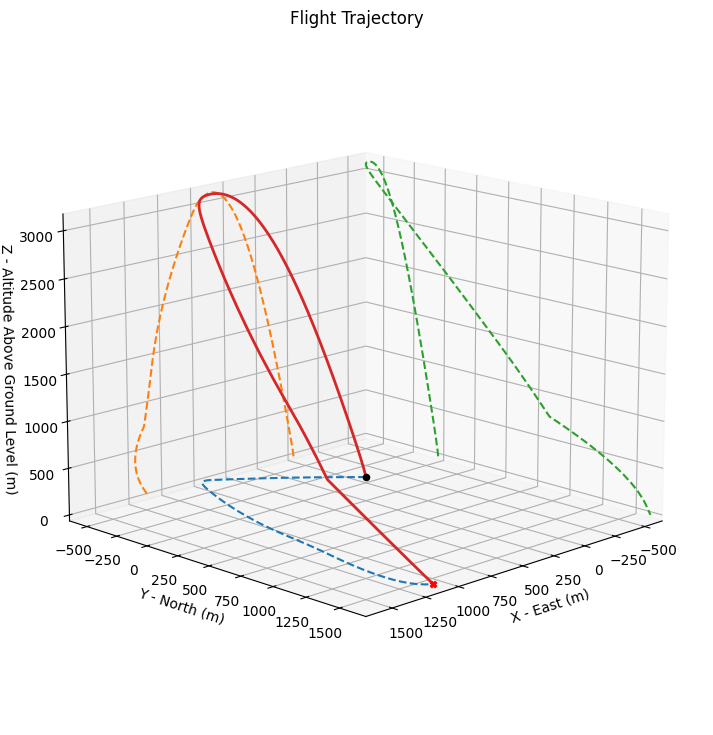

In [20]:
test_flight.plots.trajectory_3d()

### Starting the Monte Carlo Simulations


First, let's invoke the Dispersion class, we only need a filename to initialize it.
The filename will be used either to save the results of the simulations or to load them
from a previous ran simulation.


In [21]:
test_dispersion = MonteCarlo(
    filename="monte_carlo_analysis_outputs/disp_class_example4",
    environment=mc_env,
    rocket=mc_rocket,
    flight=mc_flight,
)

# TODO: add custom warning o when the rocket doesn't have a motors, parachute, or AeroSurface

Then, we can run the simulations using the method Dispersion.run_dispersion().
But before that, we need to set some simple parameters for the simulations.
We will set them by using a dictionary, which is one of the simplest way to do it.


Finally, let's iterate over the simulations and export the data from each flight simulation!


In [22]:
test_dispersion.simulate(number_of_simulations=1, append=False)

Completed 1 iterations. Total CPU time: 5.0 s. Total wall time: 5.0 sEstimated time left: 0 s
Saving results.        
Results saved to dispersion_analysis_outputs/disp_class_example4.disp_outputs.txt


### Visualizing the results


Now we finally have the results of our Monte Carlo simulations loaded!
Let's play with them.


First, we can print numerical information regarding the results of the simulations.


In [19]:
# only need to import results if you did not run the simulations
# test_dispersion.import_results()

In [20]:
test_dispersion.num_of_loaded_sims

100

In [21]:
test_dispersion.print_results()

                Parameter            Mean       Std. Dev.
------------------------------------------------------------
                   apogee         953.769          40.347
               apogeeTime          14.177           0.308
                  apogeeX         110.515          22.583
                  apogeeY         138.381          24.641
    apogeeFreestreamSpeed          18.039           2.742
                   tFinal          64.837           4.300
                  xImpact         168.630          38.868
                  yImpact         -54.877          68.694
           impactVelocity         -17.411           1.432
      initialStaticMargin           3.182           0.108
        finalStaticMargin           4.058           0.119
    outOfRailStaticMargin           3.336           0.109
            outOfRailTime           1.082           0.178
        outOfRailVelocity          23.239           2.763
                 maxSpeed         126.232           5.279
           

Secondly, we can plot the results of the simulations.


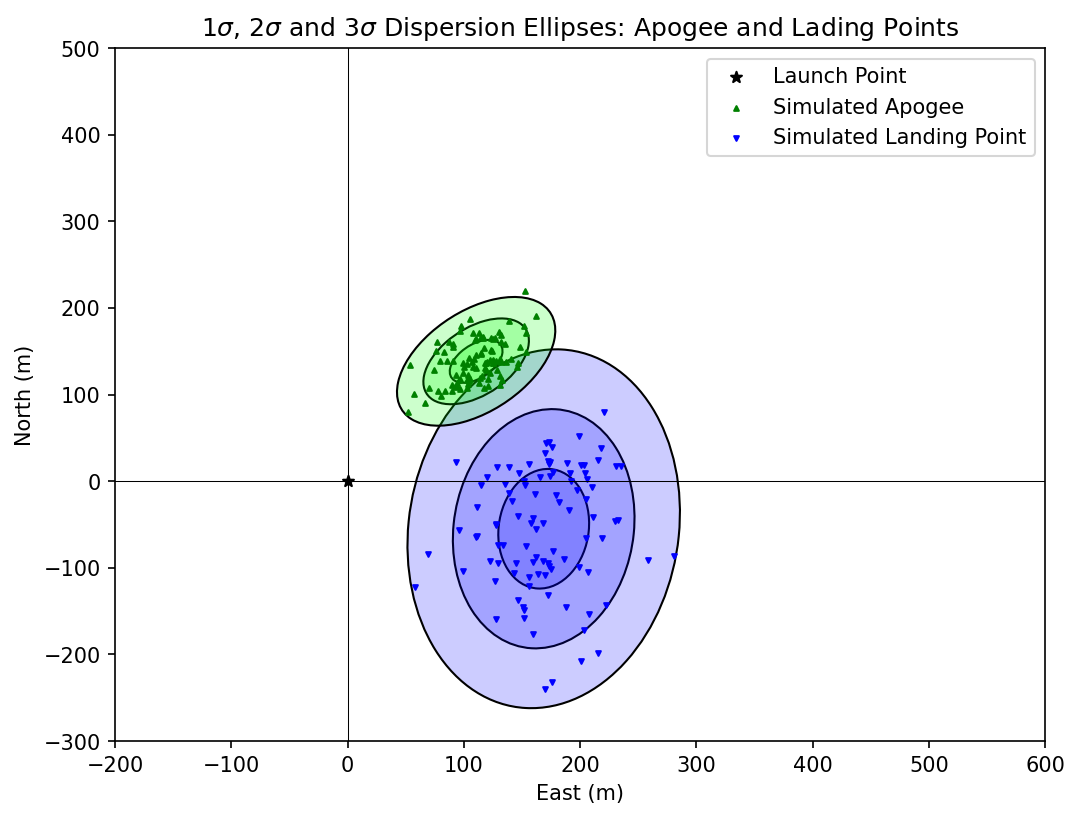

In [22]:
test_dispersion.plotEllipses(xlim=(-200, 600), ylim=(-300, 500))

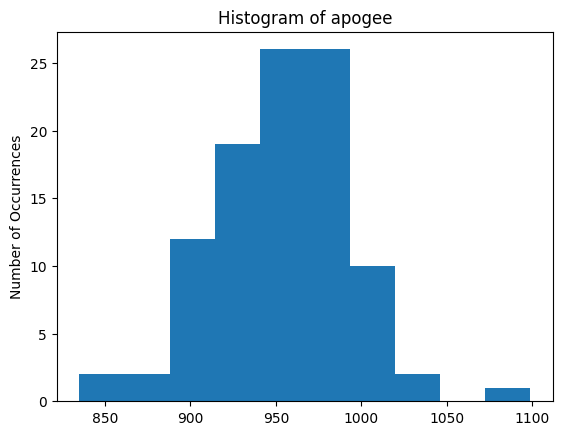

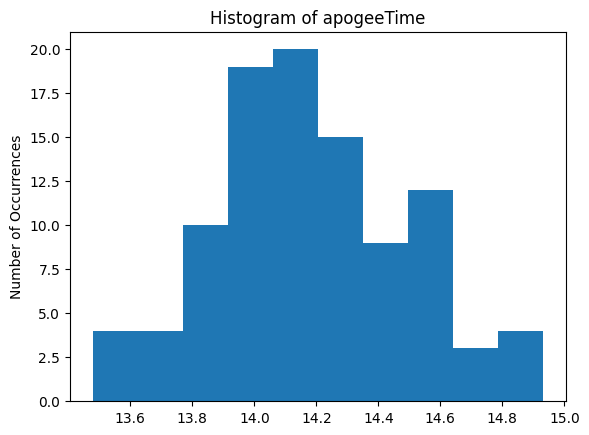

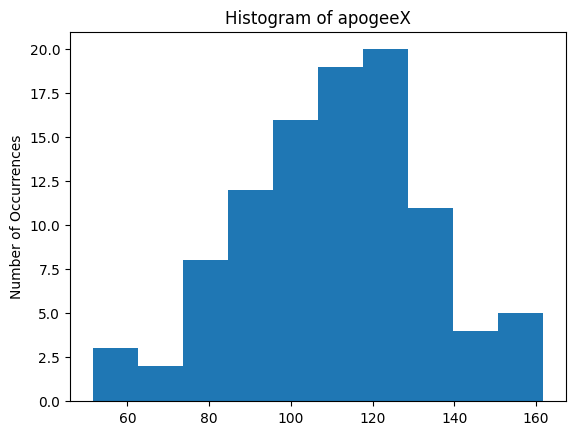

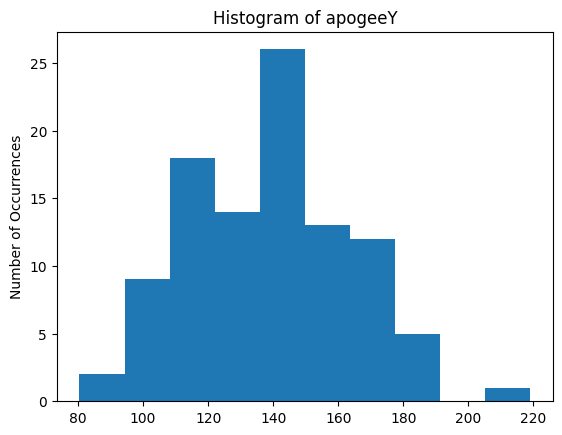

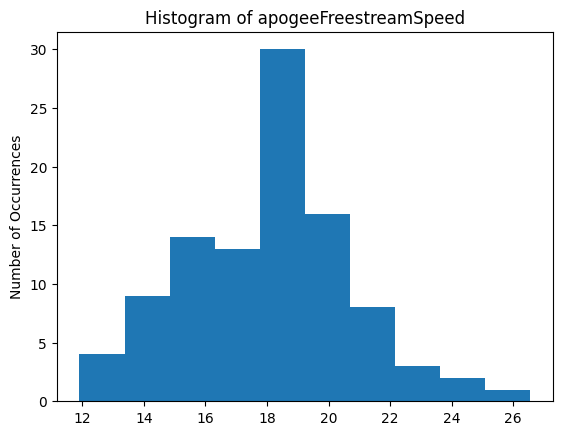

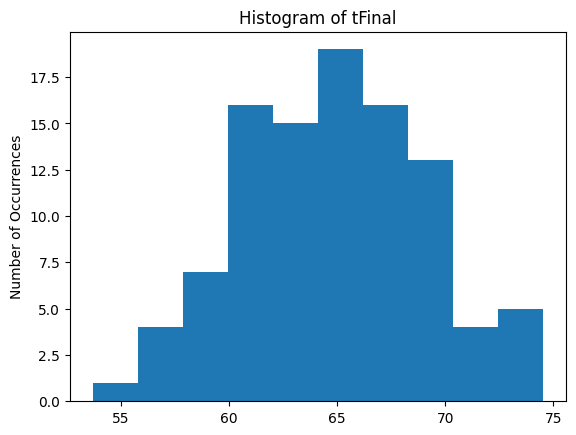

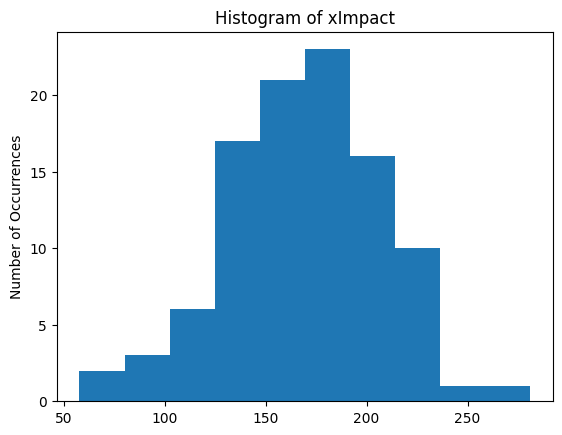

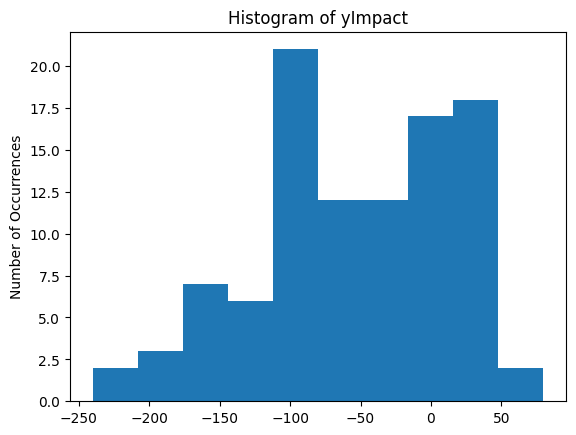

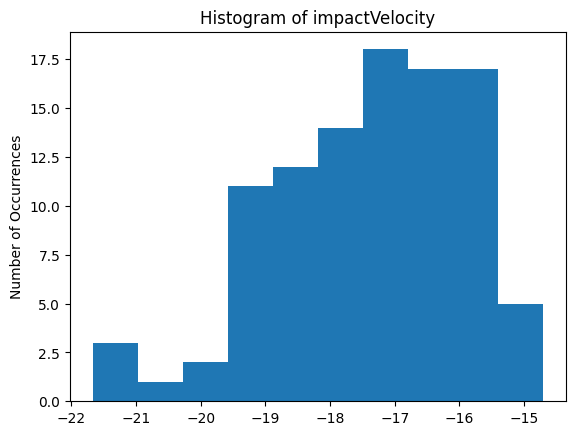

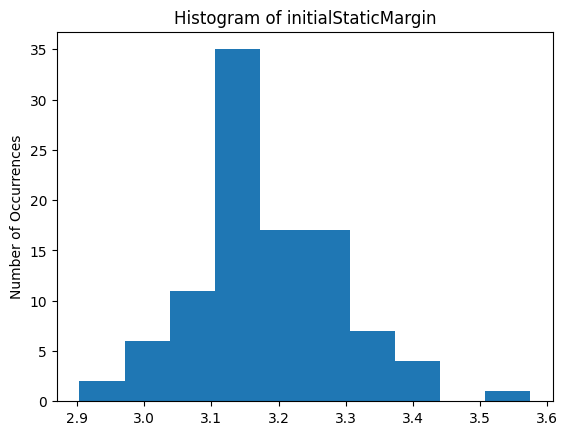

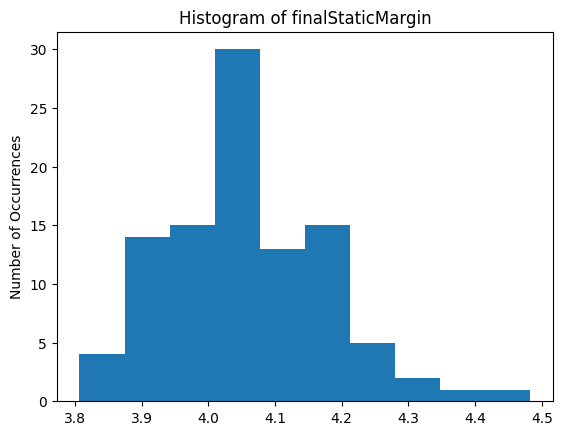

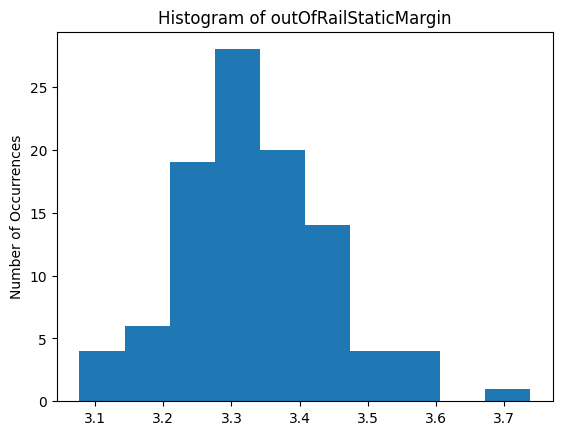

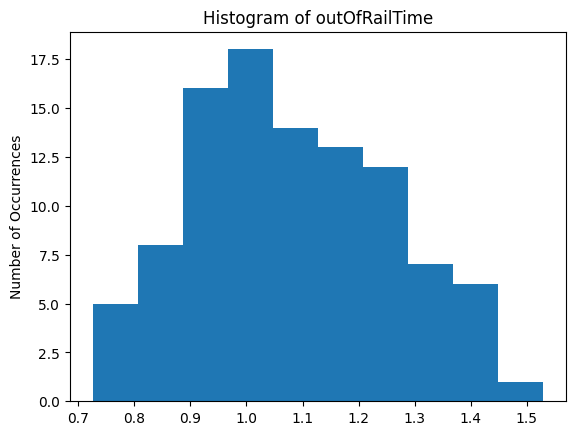

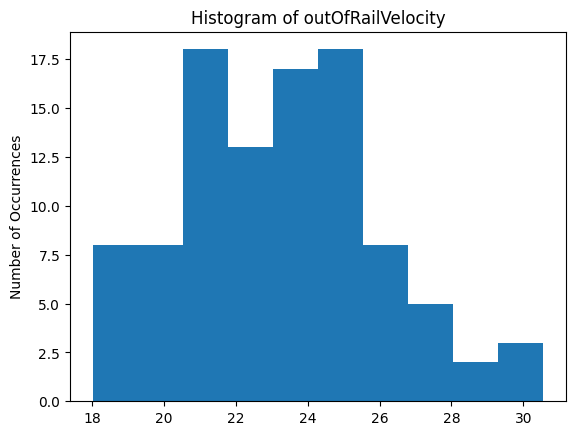

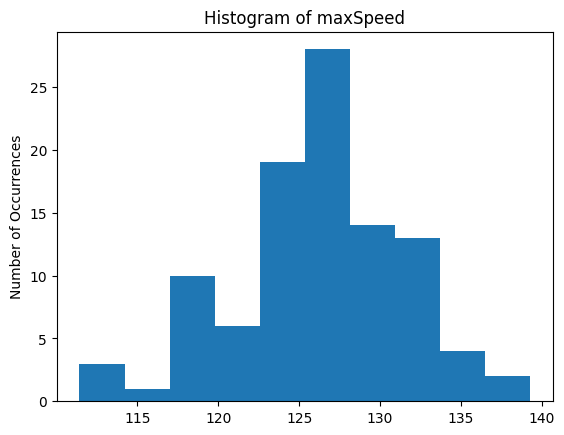

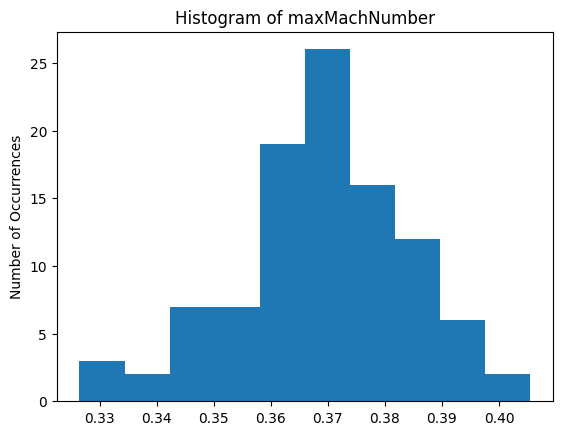

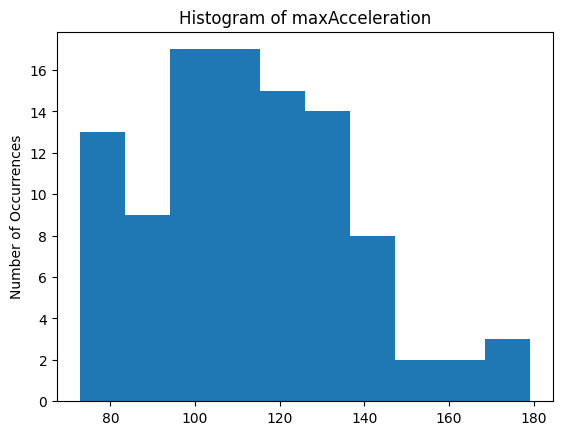

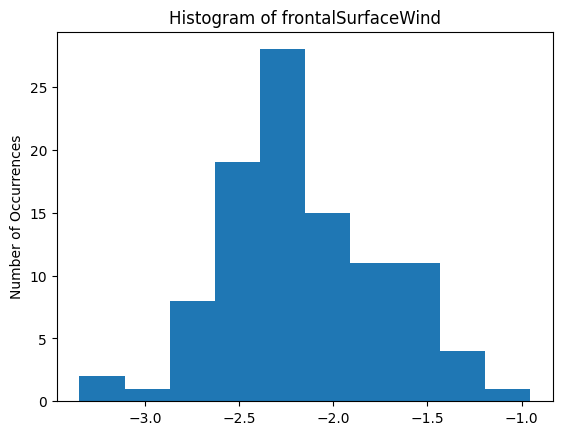

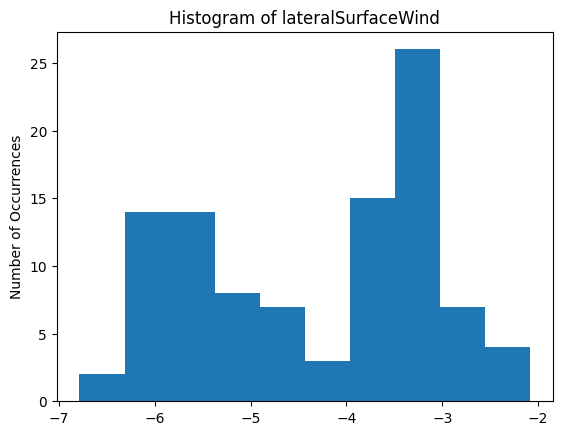

In [23]:
test_dispersion.plot_results()

Finally, one may also export to kml so it can be visualized in Google Earth


In [24]:
test_dispersion.exportEllipsesToKML(
    filename="monte_carlo_analysis_outputs/disp_class_example.kml",
    origin_lat=env.latitude,
    origin_lon=env.longitude,
    type="impact",
)